In [3]:
import pandas as pd
import json
import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import scipy.stats as stats

In [20]:
colors=['#19bdff','#f2d138'] #majority/minority
greycolor='#626262'
myblack='#222222'
# repcolor='red'
# demcolor='blue'
mygrey='#cfcfcf'
myred= '#f2d138' #'#ea9999'
mygreen= '#19bdff' #'#93c47d'
mypurple = '#7E57C2'

TINY_SIZE = 9
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

dpival=100

mpl.rcParams['figure.dpi'] = dpival

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [21]:

Q1_choices=["Acknowledges","Neutral","Denies","Debate"]
Q2_choices=["Expresses climate concern","Neutral","Expresses opposition to climate concern","Debate"]
Q3_choices=["Supports","Neutral","Opposes","Debate","Does not mention"]
short_Q2_choices=['Concern',
 'Neutral',
 'Opposition',
 'Debate'] 
short_Q3_choices=Q3_choices[:-2] #cut "does not mention"


In [22]:
df = pd.read_csv('input/allQ_df.csv', index_col=0)

In [23]:
df = df.dropna() ## drop unclears

In [24]:
df.columns

Index(['internal_id', 'media_outlet', 'climate_change', 'attitude', 'policy'], dtype='object')

In [25]:


# Split DataFrame
df_policy_mention = df[df['policy'] != 'Does not mention']
df_policy_no_mention = df[df['policy'] == 'Does not mention']

# Compute Distributions
climate_dist_mention = df_policy_mention['climate_change'].value_counts(normalize=True)
climate_dist_no_mention = df_policy_no_mention['climate_change'].value_counts(normalize=True)

attitude_dist_mention = df_policy_mention['attitude'].value_counts(normalize=True)
attitude_dist_no_mention = df_policy_no_mention['attitude'].value_counts(normalize=True)



In [26]:
# Statistical tests
def compute_stat_tests(category1, category2, dist_mention, dist_no_mention, n_mention, n_no_mention):
    """Computes Fisher's Exact Test, Chi-square Test, and Cramér's V for two given categories."""
    prop_mention_1 = dist_mention.get(category1, 0)
    prop_mention_2 = dist_mention.get(category2, 0)
    prop_no_mention_1 = dist_no_mention.get(category1, 0)
    prop_no_mention_2 = dist_no_mention.get(category2, 0)

    contingency_table = np.array([
        [prop_mention_1 * n_mention, prop_no_mention_1 * n_no_mention],
        [prop_mention_2 * n_mention, prop_no_mention_2 * n_no_mention]
    ]).astype(int)

    # Fisher's Exact Test
    oddsratio, p_fisher = stats.fisher_exact(contingency_table)

    # Chi-square test
    chi2, p_chi2, _, _ = stats.chi2_contingency(contingency_table)

    # Compute Cramér's V
    n_total = contingency_table.sum()
    phi2 = chi2 / n_total
    r, k = contingency_table.shape
    cramers_v = np.sqrt(phi2 / min(r - 1, k - 1))


    return {
        "Fisher's Exact Test p-value": p_fisher,
        "Chi-square Test χ²": chi2,
        "Chi-square Test p-value": p_chi2,
        "Cramér's V": cramers_v
    }


# Run tests for Acknowledges vs. Neutral (climate_change)
results_climate = compute_stat_tests("Acknowledges", "Neutral", climate_dist_mention, climate_dist_no_mention, n_mention_climate, n_no_mention_climate)

# Run tests for Concern vs. Neutral (attitude)
results_attitude = compute_stat_tests("Expresses climate concern", "Neutral", attitude_dist_mention, attitude_dist_no_mention, n_mention_attitude, n_no_mention_attitude)



In [27]:
def print_results(title, results):
    print(f"\n{title}")
    for key, value in results.items():
        print(f"{key}: {value}")

print_results("Climate Change (Acknowledges vs. Neutral)", results_climate)
print_results("Attitude (Concern vs. Neutral)", results_attitude)



Climate Change (Acknowledges vs. Neutral)
Fisher's Exact Test p-value: 4.498000925405648e-105
Chi-square Test χ²: 474.25647058074884
Chi-square Test p-value: 3.7978549956662094e-105
Cramér's V: 0.34528224207449937

Attitude (Concern vs. Neutral)
Fisher's Exact Test p-value: 3.63079681057761e-10
Chi-square Test χ²: 38.94030622287518
Chi-square Test p-value: 4.3696472241479777e-10
Cramér's V: 0.10114986075502372


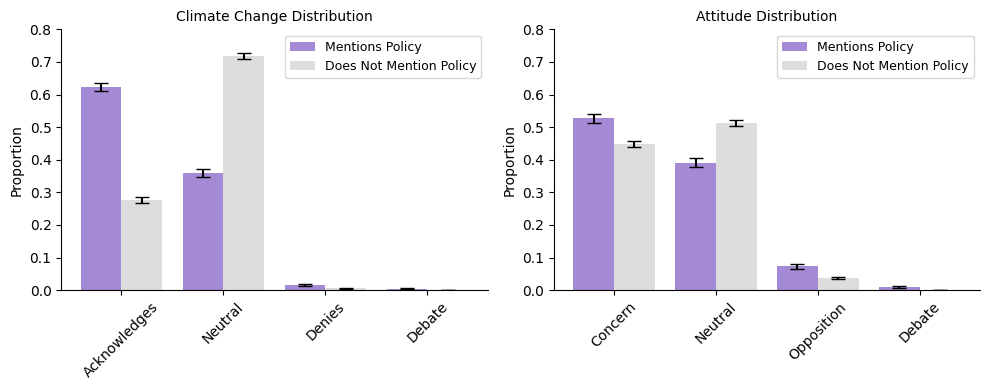

In [28]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define response categories
Q1_choices = ["Acknowledges", "Neutral", "Denies", "Debate"]
Q2_choices = ["Expresses climate concern", "Neutral", "Expresses opposition to climate concern", "Debate"]
short_Q2_choices = ['Concern', 'Neutral', 'Opposition', 'Debate']

# Function to compute distributions
def compute_distributions(df, column, categories):
    dist_mention = df[df['policy'] != 'Does not mention'][column].value_counts(normalize=True)
    dist_no_mention = df[df['policy'] == 'Does not mention'][column].value_counts(normalize=True)
    n_mention = len(df[df['policy'] != 'Does not mention'])
    n_no_mention = len(df[df['policy'] == 'Does not mention'])

    # Ensure all categories are present
    dist_mention = dist_mention.reindex(categories, fill_value=0)
    dist_no_mention = dist_no_mention.reindex(categories, fill_value=0)

    return dist_mention, dist_no_mention, n_mention, n_no_mention

def compute_multinomial_errors(dist, total):
    """
    Compute standard errors for proportions using a numerically stable
    multinomial variance approximation.
    """
    if total == 0:
        return [0] * len(dist)

    p = dist.to_numpy()

    # Alternative multinomial variance estimation that avoids overcorrection
    variance = (p * (1 - p)) / total

    # Compute errors (standard deviation) and ensure they aren't artificially zero
    errors = np.sqrt(np.maximum(variance, 1e-10))  # Ensures no artificially low values

    return errors


# Function to plot distributions
def plot_distributions(x_labels, dist_mention, dist_no_mention, err_mention, err_no_mention, title, short_labels=None):
    bar_width = 0.4
    x = np.arange(len(x_labels))

    plt.bar(x - bar_width/2, dist_mention, bar_width, yerr=err_mention, capsize=5, label='Mentions Policy', color='#7E57C2', alpha=0.7)
    plt.bar(x + bar_width/2, dist_no_mention, bar_width, yerr=err_no_mention, capsize=5, label='Does Not Mention Policy', color='#cfcfcf', alpha=0.7)

    plt.xticks(x, short_labels if short_labels else x_labels, rotation=45)
    plt.ylim(0.0,0.8)
    plt.ylabel('Proportion')
    plt.title(title)
    plt.legend()
    sns.despine()

# Recompute everything after restoring `df`
climate_dist_mention, climate_dist_no_mention, n_mention_climate, n_no_mention_climate = compute_distributions(df, 'climate_change', Q1_choices)
attitude_dist_mention, attitude_dist_no_mention, n_mention_attitude, n_no_mention_attitude = compute_distributions(df, 'attitude', Q2_choices)

# Compute multinomial-based standard errors
climate_errors_mention = compute_multinomial_errors(climate_dist_mention, n_mention_climate)
climate_errors_no_mention = compute_multinomial_errors(climate_dist_no_mention, n_no_mention_climate)
attitude_errors_mention = compute_multinomial_errors(attitude_dist_mention, n_mention_attitude)
attitude_errors_no_mention = compute_multinomial_errors(attitude_dist_no_mention, n_no_mention_attitude)

# Plot updated bar charts
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_distributions(Q1_choices, climate_dist_mention, climate_dist_no_mention, climate_errors_mention, climate_errors_no_mention, "Climate Change Distribution")

plt.subplot(1, 2, 2)
plot_distributions(Q2_choices, attitude_dist_mention, attitude_dist_no_mention, attitude_errors_mention, attitude_errors_no_mention, "Attitude Distribution", short_Q2_choices)

plt.tight_layout()
plt.show()
